In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_hub as hub



## Exploratory Data Analysis

We will be working with the "Liberals vs Conservatives on Reddit [13000 posts]" dataset from Kaggle (Gajare, 2022).

After the initial text exploration we determined it will be beneficial to combine Reddit post `Title` and `Text` columns into a single column `Combined_Text` to use for machine learning.

Additionally we performed the data cleaning and removed special characters and URLs from the text, that step is stored in the `Cleaned_Text` column.

In [ ]:
dataset_url = "https://raw.githubusercontent.com/AAI-501/aai_501_project/main/cleaned_reddit_data.csv"

In [ ]:
df = pd.read_csv(dataset_url)
display(df.head(5))

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created,Combined_Text,Cleaned_Text
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09,"No matter who someone is, how they look like, ...",no matter who someone is how they look like wh...
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09,Biden speech draws 38.2 million U.S. TV viewers,biden speech draws 382 million us tv viewers
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09,State of the union Who watched the state of th...,state of the union who watched the state of th...
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09,We Should Just Give Poor People Money,we should just give poor people money
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09,Do it for the Dew,do it for the dew


In [ ]:
df.describe()

,Score,Num of Comments,Date Created
count,12854.000000,12854.000000,1.285400e+04
mean,118.558270,19.055936,1.622576e+09
std,498.888034,60.381567,6.112838e+07
min,0.000000,0.000000,1.231048e+09
25%,3.000000,1.000000,1.632132e+09
50%,12.000000,3.000000,1.642030e+09
75%,65.000000,15.000000,1.645107e+09
max,25055.000000,2150.000000,1.646272e+09


The target column for this dataframe is `Political Lean`, so let's group the data by political lean and see the results.

In [ ]:
df.groupby(['Political Lean']).size()

Political Lean
Conservative    4535
Liberal         8319
dtype: int64

We have more rows representing `Liberal` political lean, compared to `Concervative`.

In [ ]:
df.dtypes

Title               object
Political Lean      object
Score                int64
Id                  object
Subreddit           object
URL                 object
Num of Comments      int64
Text                object
Date Created       float64
Combined_Text       object
Cleaned_Text        object
dtype: object

In [ ]:
df = df.dropna(subset=['Cleaned_Text']).loc[df['Cleaned_Text'] != '']
df['Date Created'] = pd.to_datetime(df['Date Created'],unit='s')
df

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created,Combined_Text,Cleaned_Text
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,2022-03-03 01:42:57,"No matter who someone is, how they look like, ...",no matter who someone is how they look like wh...
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,2022-03-03 01:31:48,Biden speech draws 38.2 million U.S. TV viewers,biden speech draws 382 million us tv viewers
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,2022-03-03 01:21:28,State of the union Who watched the state of th...,state of the union who watched the state of th...
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,2022-03-03 01:05:08,We Should Just Give Poor People Money,we should just give poor people money
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,2022-03-03 00:43:03,Do it for the Dew,do it for the dew
...,...,...,...,...,...,...,...,...,...,...,...
12849,Ron Paul’s Spirited Defense of WikiLeaks & Fre...,Conservative,2,em7rm,anarchocapitalism,http://www.deathandtaxesmag.com/40485/ron-paul...,1,NaN,2010-12-15 13:54:29,Ron Paul’s Spirited Defense of WikiLeaks & Fre...,ron pauls spirited defense of wikileaks free ...
12850,"“Anarcho-capitalism, in my opinion, is a doctr...",Conservative,2,ei98o,anarchocapitalism,http://www.pressaction.com/news/weblog/full_ar...,1,NaN,2010-12-08 12:53:14,"“Anarcho-capitalism, in my opinion, is a doctr...",anarchocapitalism in my opinion is a doctrinal...
12851,Mises Wiki is a wiki project dedicated to the ...,Conservative,2,e6x22,anarchocapitalism,http://wiki.mises.org/wiki/Main_Page,0,NaN,2010-11-16 12:17:27,Mises Wiki is a wiki project dedicated to the ...,mises wiki is a wiki project dedicated to the ...
12852,Fireman Protection Monopoly - Is This Failed C...,Conservative,2,e4vtd,anarchocapitalism,http://www.csmonitor.com/Business/Mises-Econom...,0,NaN,2010-11-12 01:00:34,Fireman Protection Monopoly - Is This Failed C...,fireman protection monopoly is this failed ca...


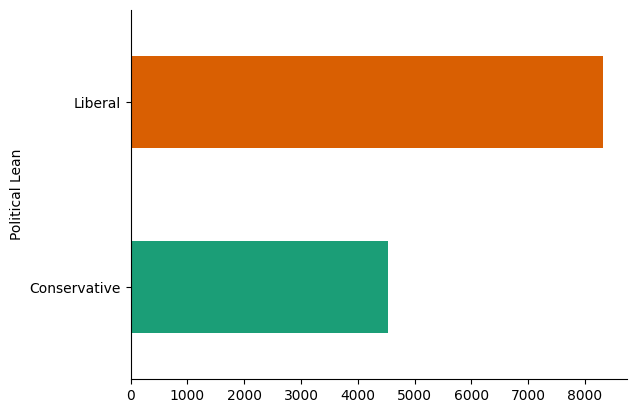

In [ ]:
df.groupby('Political Lean').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

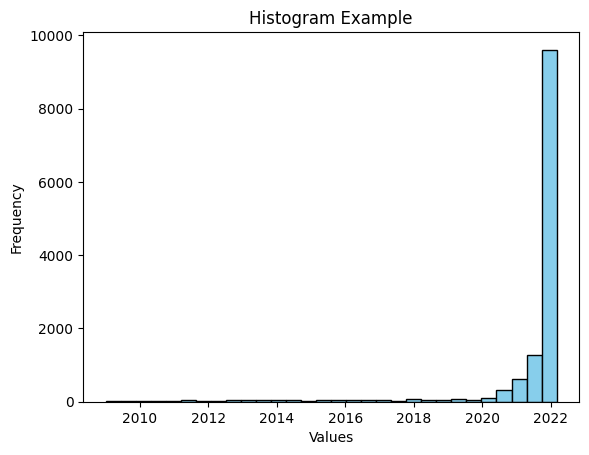

In [ ]:
# Plotting the histogram
plt.hist(df['Date Created'], bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Histogram Example')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [ ]:
display(df['Score'].sum())



1523948

## Comparative Vectorization and Model Analysis


In [ ]:
def train_and_evaluate_logit(X_train, X_test, y_train, y_test, random_state=42):
    logreg = LogisticRegression(random_state=random_state)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return report_df

def train_and_evaluate_svm(X_train, X_test, y_train, y_test, random_state=42):
    svm_classifier = SVC(random_state=random_state)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return report_df

def train_and_evaluate_nb(X_train, X_test, y_train, y_test):
    # Training a Multinomial Naive Bayes classifier

    # Find the minimum value in the training set
    min_val = np.min(X_train)

    # Shift the data to make all values non-negative
    if min_val < 0:
        X_train += abs(min_val)
        X_test += abs(min_val)

    # Create and train the classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = nb_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    return pd.DataFrame(report).transpose()

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, n_neighbors=5):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return report_df


def train_and_evaluate_rand_forest(X_train, X_test, y_train, y_test):
    rand_forest_classifier = RandomForestClassifier()
    rand_forest_classifier.fit(X_train, y_train)
    y_pred = rand_forest_classifier.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return report_df


results = {
    'TfidfVectorizer': {},
    'CountVectorizer':{},
    'USE':{}
}

In [ ]:
# X is the 'Cleaned_Text' column, y is the 'Political Lean' column
X = df['Cleaned_Text']
y = df['Political Lean']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# CountVectorizer
vectorizer_count = CountVectorizer()
X_train_count = vectorizer_count.fit_transform(X_train)
X_test_count = vectorizer_count.transform(X_test)

# Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)


# Models

In [ ]:
# SVM + TfidfVectorizer
results['TfidfVectorizer']['SVM'] = train_and_evaluate_svm(X_train_vectorized, X_test_vectorized, y_train, y_test)
display(results['TfidfVectorizer']['SVM'])

,precision,recall,f1-score,support
Conservative,0.815356,0.488499,0.610959,913.000000
Liberal,0.769269,0.939083,0.845736,1658.000000
accuracy,0.779074,0.779074,0.779074,0.779074
macro avg,0.792313,0.713791,0.728347,2571.000000
weighted avg,0.785635,0.779074,0.762363,2571.000000


In [ ]:
# SVM + CountVectorizer
results['CountVectorizer']['SVM'] = train_and_evaluate_svm(X_train_count, X_test_count, y_train, y_test)
display(results['CountVectorizer']['SVM'])

,precision,recall,f1-score,support
Conservative,0.724138,0.069003,0.126000,913.000000
Liberal,0.657810,0.985525,0.788991,1658.000000
accuracy,0.660054,0.660054,0.660054,0.660054
macro avg,0.690974,0.527264,0.457495,2571.000000
weighted avg,0.681364,0.660054,0.553553,2571.000000


In [ ]:
# SVM + Universal Sentence Encoder
results['USE']['SVM'] = train_and_evaluate_svm(X_train_embeddings.numpy(),X_test_embeddings.numpy(), y_train, y_test)
display(results['USE']['SVM'] )

,precision,recall,f1-score,support
Conservative,0.756469,0.544359,0.633121,913.000000
Liberal,0.782654,0.903498,0.838746,1658.000000
accuracy,0.775963,0.775963,0.775963,0.775963
macro avg,0.769561,0.723929,0.735933,2571.000000
weighted avg,0.773355,0.775963,0.765725,2571.000000


In [ ]:
# Naive Bayes + TfidfVectorizer
results['TfidfVectorizer']['NB']  = train_and_evaluate_nb(X_train_vectorized, X_test_vectorized, y_train, y_test)
display(results['TfidfVectorizer']['NB'] )

,precision,recall,f1-score,support
Conservative,0.907834,0.215772,0.348673,913.00000
Liberal,0.695837,0.987937,0.816550,1658.00000
accuracy,0.713730,0.713730,0.713730,0.71373
macro avg,0.801835,0.601855,0.582611,2571.00000
weighted avg,0.771120,0.713730,0.650400,2571.00000


In [ ]:
# Naive Bayes + CountVectorizer
results['CountVectorizer']['NB']  = train_and_evaluate_nb(X_train_count, X_test_count, y_train, y_test)
display(results['CountVectorizer']['NB'])

,precision,recall,f1-score,support
Conservative,0.693333,0.626506,0.658228,913.000000
Liberal,0.804696,0.847407,0.825499,1658.000000
accuracy,0.768961,0.768961,0.768961,0.768961
macro avg,0.749015,0.736956,0.741864,2571.000000
weighted avg,0.765150,0.768961,0.766099,2571.000000


In [ ]:
# Naive Bayes + Universal Sentence Encoder
results['USE']['NB']  = train_and_evaluate_nb(X_train_embeddings, X_test_embeddings , y_train, y_test)
display(results['USE']['NB'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Conservative,0.000000,0.000000,0.000000,913.000000
Liberal,0.644885,1.000000,0.784110,1658.000000
accuracy,0.644885,0.644885,0.644885,0.644885
macro avg,0.322443,0.500000,0.392055,2571.000000
weighted avg,0.415877,0.644885,0.505661,2571.000000


In [ ]:
# KNN + TfidfVectorizer
results['TfidfVectorizer']['KNN'] = train_and_evaluate_knn(X_train_vectorized, X_test_vectorized, y_train, y_test)
display(results['TfidfVectorizer']['KNN'])

,precision,recall,f1-score,support
Conservative,0.894737,0.055860,0.105155,913.000000
Liberal,0.657120,0.996381,0.791946,1658.000000
accuracy,0.662388,0.662388,0.662388,0.662388
macro avg,0.775928,0.526120,0.448550,2571.000000
weighted avg,0.741501,0.662388,0.548056,2571.000000


In [ ]:
# KNN + CountVectorizer
results['CountVectorizer']['KNN']  = train_and_evaluate_knn(X_train_count, X_test_count, y_train, y_test)
display(results['CountVectorizer']['KNN'])

,precision,recall,f1-score,support
Conservative,0.457847,0.386637,0.419240,913.000000
Liberal,0.688889,0.747889,0.717178,1658.000000
accuracy,0.619603,0.619603,0.619603,0.619603
macro avg,0.573368,0.567263,0.568209,2571.000000
weighted avg,0.606842,0.619603,0.611376,2571.000000


In [ ]:
# KNN + Universal Sentence Encoder
results['USE']['KNN'] = train_and_evaluate_knn(X_train_embeddings.numpy(), X_test_embeddings.numpy(), y_train, y_test)
display(results['USE']['KNN'])

,precision,recall,f1-score,support
Conservative,0.670442,0.648412,0.659243,913.00000
Liberal,0.809834,0.824487,0.817095,1658.00000
accuracy,0.761960,0.761960,0.761960,0.76196
macro avg,0.740138,0.736450,0.738169,2571.00000
weighted avg,0.760334,0.761960,0.761039,2571.00000


In [ ]:
#  Logistic Regression + TfidfVectorizer
results['TfidfVectorizer']['LR'] = train_and_evaluate_logit(X_train_vectorized, X_test_vectorized, y_train, y_test)
display(results['TfidfVectorizer']['LR'])

,precision,recall,f1-score,support
Conservative,0.773050,0.477547,0.590386,913.000000
Liberal,0.762332,0.922799,0.834925,1658.000000
accuracy,0.764683,0.764683,0.764683,0.764683
macro avg,0.767691,0.700173,0.712655,2571.000000
weighted avg,0.766138,0.764683,0.748086,2571.000000


In [ ]:
# Logistic Regression + CountVectorizer
results['CountVectorizer']['LR'] = train_and_evaluate_logit(X_train_count, X_test_count, y_train, y_test)
display(results['CountVectorizer']['LR'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,precision,recall,f1-score,support
Conservative,0.710561,0.596933,0.648810,913.000000
Liberal,0.796009,0.866104,0.829578,1658.000000
accuracy,0.770517,0.770517,0.770517,0.770517
macro avg,0.753285,0.731518,0.739194,2571.000000
weighted avg,0.765665,0.770517,0.765385,2571.000000


In [ ]:
# Logistic Regression + Universal Sentence Encoder

results['USE']['LR'] = train_and_evaluate_logit(X_train_embeddings.numpy(), X_test_embeddings.numpy(), y_train, y_test)
display(results['USE']['LR'])

,precision,recall,f1-score,support
Conservative,0.649148,0.500548,0.565244,913.000000
Liberal,0.755758,0.851025,0.800567,1658.000000
accuracy,0.726566,0.726566,0.726566,0.726566
macro avg,0.702453,0.675786,0.682906,2571.000000
weighted avg,0.717899,0.726566,0.717001,2571.000000


In [ ]:
# Random Forest + TfidfVectorizer
results['TfidfVectorizer']['RF'] = train_and_evaluate_rand_forest(X_train_vectorized, X_test_vectorized, y_train, y_test)
display(results['TfidfVectorizer']['RF'] )

,precision,recall,f1-score,support
Conservative,0.770435,0.485214,0.595430,913.00000
Liberal,0.764529,0.920386,0.835249,1658.00000
accuracy,0.765850,0.765850,0.765850,0.76585
macro avg,0.767482,0.702800,0.715340,2571.00000
weighted avg,0.766626,0.765850,0.750086,2571.00000


In [ ]:
# Random Forest + CountVectorizer
results['CountVectorizer']['RF'] = train_and_evaluate_rand_forest(X_train_count, X_test_count, y_train, y_test)
display(results['CountVectorizer']['RF'])

,precision,recall,f1-score,support
Conservative,0.786667,0.516977,0.623926,913.000000
Liberal,0.776256,0.922799,0.843207,1658.000000
accuracy,0.778685,0.778685,0.778685,0.778685
macro avg,0.781461,0.719888,0.733567,2571.000000
weighted avg,0.779953,0.778685,0.765337,2571.000000


In [ ]:
# Random Forest + Universal Sentence Encoder
results['USE']['RF'] = train_and_evaluate_rand_forest(X_train_embeddings.numpy(), X_test_embeddings.numpy(), y_train, y_test)
display(results['USE']['RF'])

,precision,recall,f1-score,support
Conservative,0.779582,0.368018,0.500000,913.000000
Liberal,0.730374,0.942702,0.823065,1658.000000
accuracy,0.738623,0.738623,0.738623,0.738623
macro avg,0.754978,0.655360,0.661532,2571.000000
weighted avg,0.747849,0.738623,0.708340,2571.000000


# Accuracy Check

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'SVM'),
  Text(1, 0, 'NB'),
  Text(2, 0, 'KNN'),
  Text(3, 0, 'LR'),
  Text(4, 0, 'RF')])

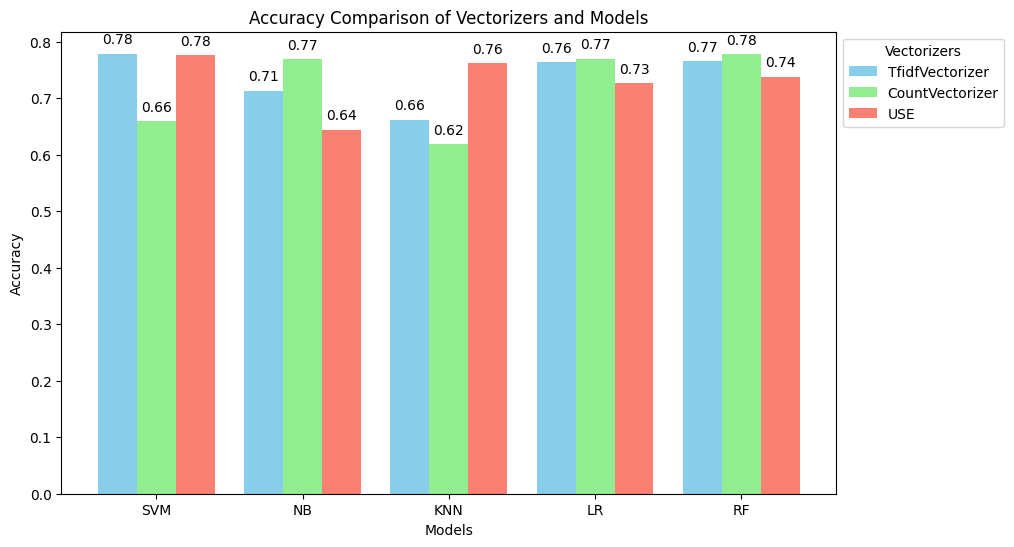

In [ ]:
def extract_accuracies(data):
    """
    Extract accuracies from a nested dictionary where the innermost elements are DataFrames.
    """
    accuracies = {}
    for vectorizer, models in data.items():
        accuracies[vectorizer] = {}
        for model, df in models.items():
            # Extracting the accuracy value
            accuracy = df.loc['accuracy', 'support']
            accuracies[vectorizer][model] = accuracy
    return accuracies


accuracy_dict_from_df = extract_accuracies(results)
accuracy_df_full = pd.DataFrame(accuracy_dict_from_df)

ax = accuracy_df_full.plot(kind='bar', figsize=(10, 6), width=0.8, color=['skyblue', 'lightgreen', 'salmon'])

ax.set_title('Accuracy Comparison of Vectorizers and Models')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.legend(title='Vectorizers', loc='upper left', bbox_to_anchor=(1, 1))

# Adding numbers on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=0)

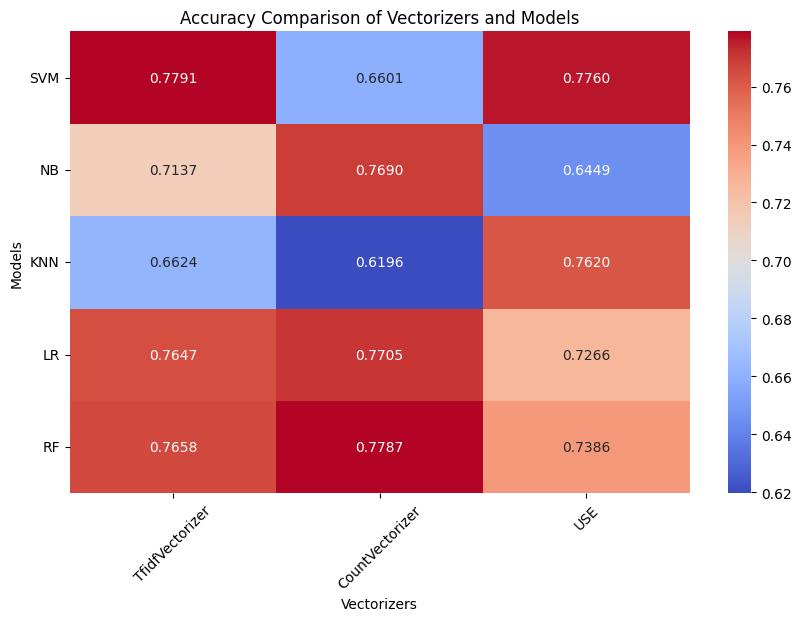

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(accuracy_df_full, annot=True, fmt=".4f", cmap="coolwarm")

# Setting the title and labels
ax.set_title('Accuracy Comparison of Vectorizers and Models')
ax.set_xlabel('Vectorizers')
ax.set_ylabel('Models')

# Adjust layout
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
accuracy_series = accuracy_df_full.stack()

top_5_accuracies = accuracy_series.sort_values(ascending=False).head(5)
top_5_list = list(top_5_accuracies.index)

top_5_accuracies_print = "\n".join([
    f"{idx + 1}. {model} with {vectorizer}\n\t Accuracy: {accuracy:.4f}%"
    for idx, ((vectorizer, model), accuracy) in enumerate(top_5_accuracies.items())
])

print(top_5_accuracies_print)

1. TfidfVectorizer with SVM
	 Accuracy: 0.7791%
2. CountVectorizer with RF
	 Accuracy: 0.7787%
3. USE with SVM
	 Accuracy: 0.7760%
4. CountVectorizer with LR
	 Accuracy: 0.7705%
5. CountVectorizer with NB
	 Accuracy: 0.7690%


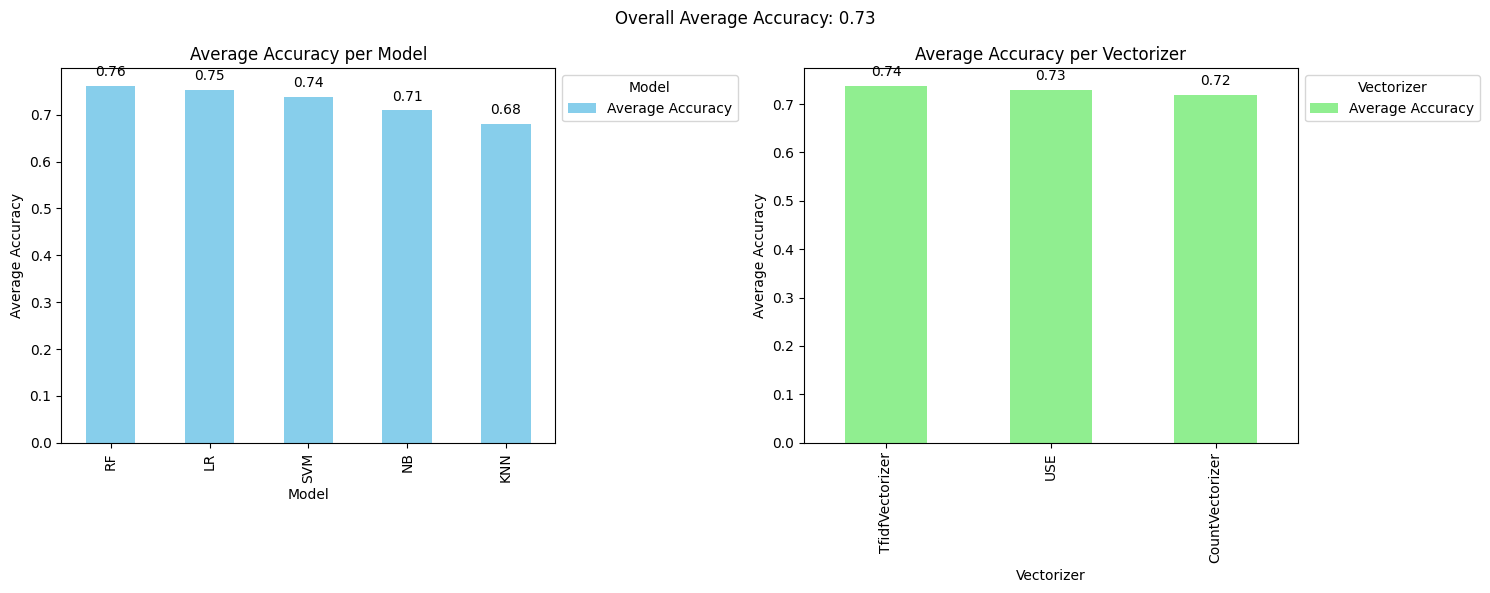

In [ ]:
# Correct calculations for average accuracies

# Average accuracy for each model across all vectorizers
average_accuracy_per_model_corrected = accuracy_df_full.mean(axis=1)

# Average accuracy for each vectorizer across all models
average_accuracy_per_vectorizer_corrected = accuracy_df_full.mean(axis=0)

# Overall average accuracy across all models and vectorizers
overall_average_accuracy_corrected = accuracy_df_full.stack().mean()

# Preparing data for visualization
model_averages_df = average_accuracy_per_model_corrected.reset_index()
model_averages_df.columns = ['Model', 'Average Accuracy']

vectorizer_averages_df = average_accuracy_per_vectorizer_corrected.reset_index()
vectorizer_averages_df.columns = ['Vectorizer', 'Average Accuracy']

# Sorting data
model_averages_df_sorted = model_averages_df.sort_values(by='Average Accuracy', ascending=False)
vectorizer_averages_df_sorted = vectorizer_averages_df.sort_values(by='Average Accuracy', ascending=False)

# Plotting with numbers on bars
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for models
model_averages_df_sorted.plot(x='Model', y='Average Accuracy', kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Average Accuracy per Model')
ax[0].set_ylabel('Average Accuracy')
ax[0].set_xlabel('Model')
ax[0].legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
# Adding numbers on top of each bar for models
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot for vectorizers
vectorizer_averages_df_sorted.plot(x='Vectorizer', y='Average Accuracy', kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Average Accuracy per Vectorizer')
ax[1].set_ylabel('Average Accuracy')
ax[1].set_xlabel('Vectorizer')
ax[1].legend(title='Vectorizer', loc='upper left', bbox_to_anchor=(1, 1))
# Adding numbers on top of each bar for vectorizers
for p in ax[1].patches:
    ax[1].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.suptitle(f'Overall Average Accuracy: {overall_average_accuracy_corrected:.2f}')
plt.tight_layout()
plt.show()


## Model Selection

Based on the model performances, the best performing candiate is:
   - `Support Vector Machine` with `TfidfVectorizer`.

These are surprising results, since `TfidVectorizer` does not reflect the semantics of the Reddit posts. However, vectors created with `TfidVectorizer` reflect the importance of the word in the corpus.

## Conclusion

None of the techiques created the execptional results - i.e. accuracy for all the classification algorithms was below $80\%$

`Support Vector Machine` algorithm performed the best for classification Reddit posts and for predicting `Political Lean`.